# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, AveragePooling1D, MaxPooling1D
from tensorflow.keras.layers import Conv1D, AveragePooling1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, Nadam 
from tensorflow.keras.regularizers import l1, l2, l1_l2

# Load Data

In [2]:
# Load Data 
from google.colab import files
uploaded = files.upload()

Saving USD_JPY Historical Data.csv to USD_JPY Historical Data.csv
Saving USD_JPY Test.csv to USD_JPY Test.csv


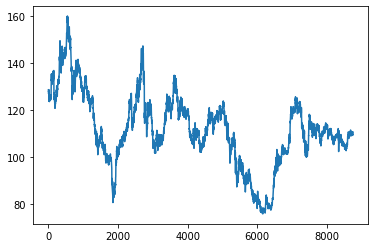

In [3]:
dataframe = pd.read_csv('USD_JPY Historical Data.csv', usecols=[1])
plt.plot(dataframe)

# Prepare Data (Training set)

In [4]:
# convert pandas dataframe to numpy array (when dealing with NN, have to convert to np array)
dataset = dataframe.values
dataset = dataset.astype('float32') #convert values to float instead of integer 
dataset.dtype

dtype('float32')

In [5]:
#Normalization is optional but recommended for neural network as certain 
#activation functions are sensitive to magnitude of numbers. 
#normalization of the dataset 
scaler = MinMaxScaler(feature_range=(0,1)) 
#scale the value of dataset to be scalled to value between 0-1 instead because activation function in NN prefer value 0-1
dataset = scaler.fit_transform(dataset)
dataset[:5]

array([[0.62764686],
       [0.61789197],
       [0.61836785],
       [0.62217456],
       [0.6193195 ]], dtype=float32)

In [6]:
prediction_days = 5

x_train = []
y_train = []

for x in range(prediction_days, len(dataset)): 
  x_train.append(dataset[x-prediction_days:x, 0])
  y_train.append(dataset[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train[1], y_train[1])
x_train.shape

[[0.61789197]
 [0.61836785]
 [0.62217456]
 [0.6193195 ]
 [0.6118248 ]] 0.6071853


(8744, 5, 1)

# Build the Model 

In [7]:
#While training the neural network, it is important that we use the MSE error of the validation set to decide when to 
#stop training our network. If we use the MSE of the training set, we will not get good predictions in the test set due 
#to over fitting. However, unlike the error in the training set, the error in the validation set does not reduce with 
#every passing epoch. Sometimes, it increases for a while before it starts declining. The patience argument in Earlystop allows us 
#to decide how many times we want the validation error to keep increasing before we stop training the neural network.

#EarlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto',restore_best_weights=True)

epochs = 100 #number of times the feed forward mechanism and back propagation are repeated 

bs = 32 #batch size for SGD :show what happens when batch size very small
lr =0.001 #learning rate: the degree to which the weights are updated by each batch of SGD

sgd = SGD(lr=lr) #type of optimizer - Alternative: ADAM, NADAM

model = Sequential() #initializing keras Sequential model

#convolutional layer starts
model.add(Conv1D(filters=32,#number of filters
                 kernel_size=2,#size of the filter across time
                 strides=2, #number of rows that the filter moves ahead by
                 activation='relu',#transformation
                 input_shape=(x_train.shape[1], 1))) #shape of 1 sample : preserves temporal structure
                #kernel_regularizer=l2(0.009),, bias_regularizer=l2(0.01)
#convolutional layer ends

model.add(MaxPooling1D(pool_size=1)) #sub-sampling layer - Alternative: AveragePooling1D

#model.add(BatchNormalization())
model.add(Dropout(0.1)) #reduces overfitting by dropping some weights randomly

#regression layer begins
model.add(Flatten())
model.add(Dense(1,#number of outputs
                activation='tanh',#transformation:other options include - ReLU,Linear,Sigmoid
                kernel_regularizer=l2(0.01))) 

model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc']) #specifies which optimizer and loss funtion to useto use 

#training the model
history = model.fit(x_train, y_train,
          batch_size=bs,
          epochs=epochs, 
          #callbacks= [EarlyStop],
          verbose=2, 
          shuffle=False)  #always set to false for time series data

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


274/274 - 1s - loss: 0.0235 - acc: 1.1436e-04 - 875ms/epoch - 3ms/step
Epoch 2/100
274/274 - 0s - loss: 0.0107 - acc: 1.1436e-04 - 371ms/epoch - 1ms/step
Epoch 3/100
274/274 - 0s - loss: 0.0077 - acc: 1.1436e-04 - 368ms/epoch - 1ms/step
Epoch 4/100
274/274 - 0s - loss: 0.0059 - acc: 1.1436e-04 - 342ms/epoch - 1ms/step
Epoch 5/100
274/274 - 0s - loss: 0.0050 - acc: 1.1436e-04 - 337ms/epoch - 1ms/step
Epoch 6/100
274/274 - 0s - loss: 0.0043 - acc: 1.1436e-04 - 324ms/epoch - 1ms/step
Epoch 7/100
274/274 - 0s - loss: 0.0040 - acc: 1.1436e-04 - 333ms/epoch - 1ms/step
Epoch 8/100
274/274 - 0s - loss: 0.0038 - acc: 1.1436e-04 - 347ms/epoch - 1ms/step
Epoch 9/100
274/274 - 0s - loss: 0.0036 - acc: 1.1436e-04 - 341ms/epoch - 1ms/step
Epoch 10/100
274/274 - 0s - loss: 0.0034 - acc: 1.1436e-04 - 328ms/epoch - 1ms/step
Epoch 11/100
274/274 - 0s - loss: 0.0033 - acc: 1.1436e-04 - 338ms/epoch - 1ms/step
Epoch 12/100
274/274 - 0s - loss: 0.0031 - acc: 1.1436e-04 - 327ms/epoch - 1ms/step
Epoch 13/100


In [8]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 32)             96        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 32)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 32)             0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
__________________________________________________________

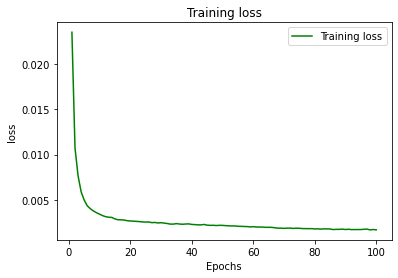

In [9]:
loss_train = history.history['loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Test the Model Accuracy on Existing Data

In [10]:
#Load the Test Data
dataframe2 = pd.read_csv('USD_JPY Test.csv', usecols=[4])
actual_prices = dataframe2.values
total_dataset = pd.concat((dataframe['Price'], dataframe2['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset)-len(dataframe2) - prediction_days:].values
model_inputs= model_inputs.reshape (-1,1)
model_inputs = scaler.transform(model_inputs)

In [11]:
# Make Predictions on Test Data
x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

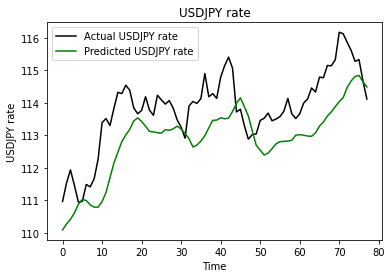

In [12]:
# Plot the test prediction 

plt.plot(actual_prices, color='black', label =f'Actual USDJPY rate')
plt.plot(predicted_prices, color='green', label=f"Predicted USDJPY rate")
plt.title(f"USDJPY rate")
plt.xlabel('Time')
plt.ylabel(f'USDJPY rate')
plt.legend()
plt.show()

In [13]:
predicted_prices [60:]

array([[113.02103 ],
       [113.00402 ],
       [112.978065],
       [112.97044 ],
       [113.07556 ],
       [113.28411 ],
       [113.41214 ],
       [113.59556 ],
       [113.7201  ],
       [113.88502 ],
       [114.04018 ],
       [114.161865],
       [114.471405],
       [114.67114 ],
       [114.81373 ],
       [114.84382 ],
       [114.64708 ],
       [114.48985 ]], dtype=float32)

In [14]:
#Predict Next Day 

real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f'Prediction: {prediction}')


Prediction: [[114.223755]]
